[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Exploring Different Vision Tasks with Florence-2

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/florence-2/)
[![arXiv](https://img.shields.io/badge/arXiv-2311.06242-b31b1b.svg)](https://arxiv.org/abs/2311.06242)

## Setup

### Configure your API keys

To run Florence-2, you need to provide your HuggingFace Token. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store HuggingFace Access Token under the name `HF_TOKEN`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Wed Jul  3 11:47:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Install extra dependencies

 Let's download the model checkpoint and configure it so that you can fine-tune it later on.

In [1]:
!pip install -q transformers timm einops supervision==0.22.0rc1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download example data

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


**NONE:** Let's download few example images. Feel free to use your images or videos.

In [ ]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/inference/license_plate_1.jpg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/handwritten-text.jpg -P {HOME}/data

## Load pre-trained Florence-2 model

Load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor` classes from the transformers library. Note that you need to pass `trust_remote_code` as `True` since this model is not a standard transformers model.

In [ ]:
!pip uninstall flash-attn -y
!pip install flash-attn==2.5.8 --no-build-isolation

Found existing installation: flash_attn 2.8.1
Uninstalling flash_attn-2.8.1:
  Successfully uninstalled flash_attn-2.8.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.0 kB)
Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (422 kB)
ERROR: Operation cancelled by user
^C


In [2]:
import torch
from transformers import AutoProcessor, AutoModelForCausalLM

CHECKPOINT = "microsoft/Florence-2-base-ft"
#CHECKPOINT = "microsoft/Florence-2-large-ft"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 

## Run inference with pre-trained Florence-2 model

In [12]:
!pip install transformers==4.51.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 47.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.2
    Uninstalling transformers-4.53.2:
      Successfully uninstalled transformers-4.53.2


In [11]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [4]:
!pip show flash-attn
!pip show transformers

Name: transformers
Version: 4.51.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


{'<OD>': {'bboxes': [[125.2125015258789, 52.70499801635742, 224.90550231933594, 116.61499786376953], [135.7064971923828, 162.26499938964844, 172.91250610351562, 235.30499267578125]], 'labels': ['shower cap', 'shower cap']}}


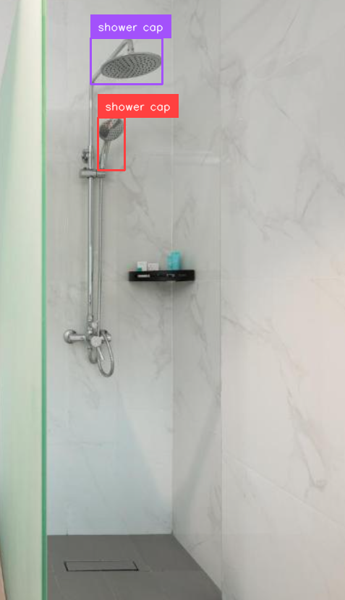

In [77]:
# @title Example object detection (`<OB>`) inference

import supervision as sv
from PIL import Image

image = Image.open(f"/content/drive/MyDrive/hotel_demo/chrome_vDwhuxxoyx.png")
# Convert to RGB if needed
if image.mode != 'RGB':
    image = image.convert('RGB')

text = "<OD>"
task = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response2 = processor.post_process_generation(generated_text, task=task, image_size=image.size)
print(response2)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response2, resolution_wh=image.size)
bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [73]:
keep_classes = ["bed", "pillow", "chair", "desk",
                "television", "trash bin/can", "coffee table",
                "studio couch", "coffee maker", 'microwave oven',
                'toaster', "towel", "toilet paper", "shower cap",
                "towels/napkin", "bathtub"]
response = response2.copy()
# Loop in reverse order to avoid index shifting when removing items
for i in range(len(response['<OD>']['labels']) - 1, -1, -1):
    label = response['<OD>']['labels'][i]
    if label not in keep_classes:
        print(f"Removing index {i}: {label}")
        # Remove both label and corresponding bbox
        del response['<OD>']['labels'][i]
        del response['<OD>']['bboxes'][i]
    else:
        print(f"Keeping index {i}: {label}")

print(f"Final count: {len(response['<OD>']['labels'])}")
print("Final labels:", response['<OD>']['labels'])
print(response)

Keeping index 11: towels/napkin
Keeping index 10: towels/napkin
Removing index 9: towel rack
Keeping index 8: toilet paper
Removing index 7: sink
Removing index 6: sink
Keeping index 5: shower cap
Removing index 4: mirror
Removing index 3: hinge
Removing index 2: hinge
Removing index 1: hinge
Removing index 0: faucet
Final count: 4
Final labels: ['shower cap', 'toilet paper', 'towels/napkin', 'towels/napkin']
{'<OD>': {'bboxes': [[579.4159545898438, 91.72349548339844, 633.5599975585938, 118.09049987792969], [118.43999481201172, 491.71649169921875, 171.83200073242188, 554.5484619140625], [534.2959594726562, 356.5155029296875, 606.4879760742188, 515.2785034179688], [237.25599670410156, 396.9075012207031, 304.1839904785156, 467.593505859375]], 'labels': ['shower cap', 'toilet paper', 'towels/napkin', 'towels/napkin']}}


In [74]:
image = Image.open(f"/content/drive/MyDrive/hotel_demo/chrome_l76iq38t6w.png")
# Convert to RGB if needed
if image.mode != 'RGB':
    image = image.convert('RGB')

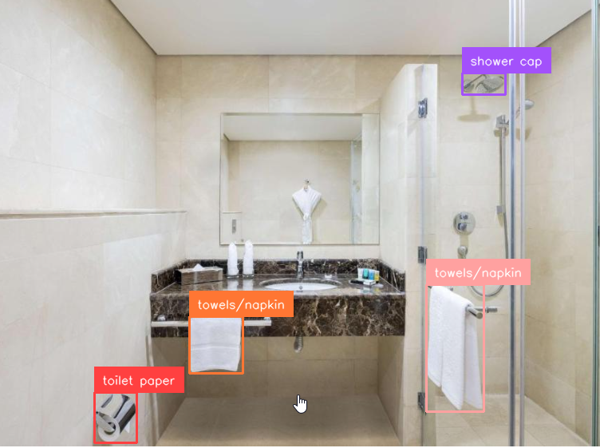

In [75]:
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [76]:
image.save("img.jpg")

**NOTE:** Note that out of the box Florence-2 detects far more classes than the typical model pretreated on the COCO dataset.

In [79]:
 # @title Wrap inference code into utility function

def run_inference(image: Image, task: str, text: str = ""):
    prompt = task + text
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(generated_text, task=task, image_size=image.size)

**NOTE:** Florence-2 offers 3 types of imag caption tasks - `<CAPTION>`, `<DETAILED_CAPTION>`, `<MORE_DETAILED_CAPTION>` differing in level of detail. Let's compare the results obtained.

In [ ]:
# @title Example `<CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<CAPTION>"

response = run_inference(image=image, task=task)
response

{'<CAPTION>': 'A man sitting in a chair holding a dog.'}

In [ ]:
# @title Example `<DETAILED_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
response

{'<DETAILED_CAPTION>': 'In this image I can see a person sitting on the chair and holding a dog. There is a cup and a mobile on the table. There are chairs and tables. At the back there is a building and there are trees.'}

In [ ]:
# @title Example `<MORE_DETAILED_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<MORE_DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
response

{'<MORE_DETAILED_CAPTION>': 'A man is sitting outside on a wicker chair. He is wearing a black cap, sunglasses and a blue shirt. The man is holding a brown and white dog in his lap. There is a black table in front of the man with a white coffee cup on it. Part of a building can be seen behind the man. Large green trees are standing on the side of the building.'}

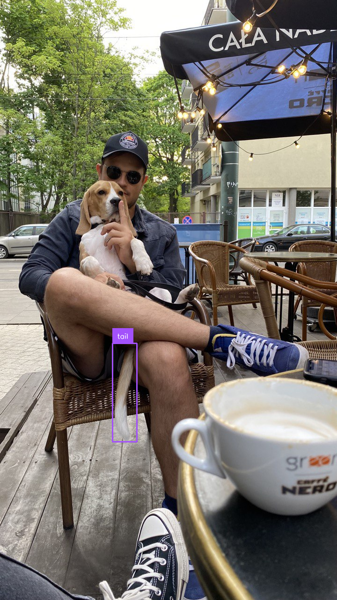

In [ ]:
# @title Example `<CAPTION_TO_PHRASE_GROUNDING>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<CAPTION_TO_PHRASE_GROUNDING>"
text = "tail"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In this image I can see a person sitting on the chair and holding a dog. There is a cup and a mobile on the table. There are chairs and tables. At the back there is a building and there are trees.


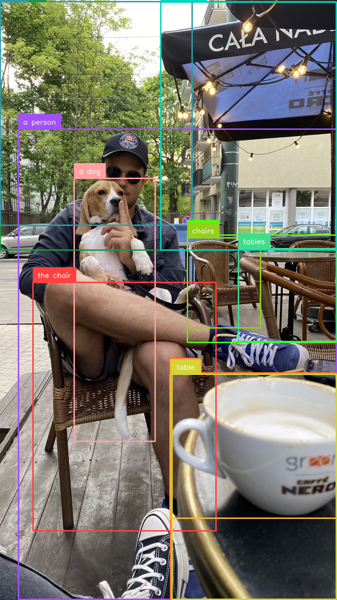

In [ ]:
# @title Example `<DETAILED_CAPTION>` + `<CAPTION_TO_PHRASE_GROUNDING>` combo inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
text = response[task]

task = "<CAPTION_TO_PHRASE_GROUNDING>"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))

print(text)
image

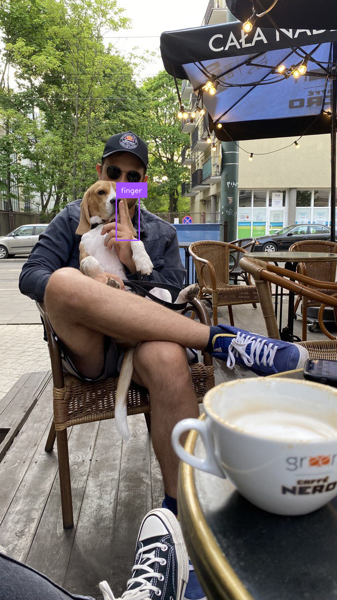

In [ ]:
# @title Example `<OPEN_VOCABULARY_DETECTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<OPEN_VOCABULARY_DETECTION>"
text = "finger"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

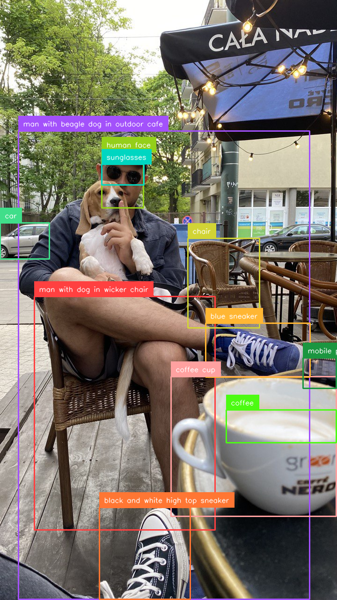

In [ ]:
# @title Example `<DENSE_REGION_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<DENSE_REGION_CAPTION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

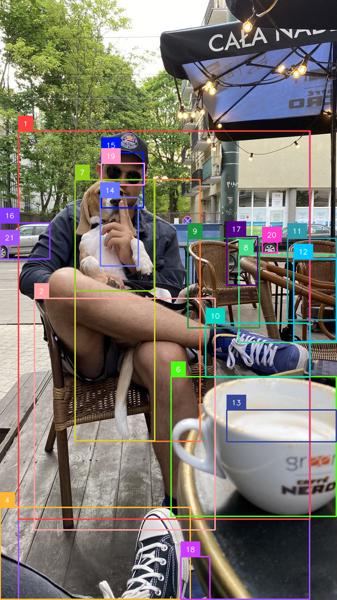

In [ ]:
# @title Example `<REGION_PROPOSAL>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<REGION_PROPOSAL>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

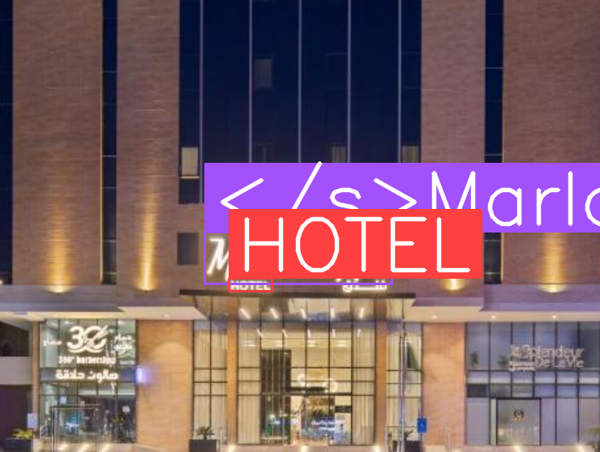

In [82]:
# @title Example `<OCR_WITH_REGION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"/content/drive/MyDrive/hotel_demo/chrome_VvGZBVnpbZ.png")
task = "<OCR_WITH_REGION>"

if image.mode != 'RGB':
    image = image.convert('RGB')

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    text_scale=3,
    text_thickness=4
)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

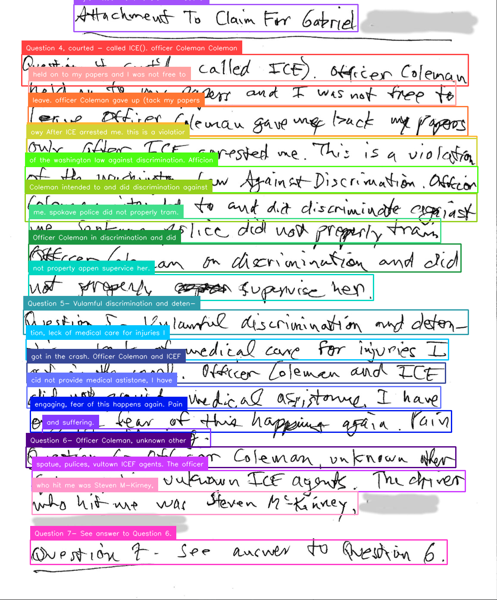

In [ ]:
import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/handwritten-text.jpg")
task = "<OCR_WITH_REGION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [ ]:
# @title Example `<OCR>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/handwritten-text.jpg")
task = "<OCR>"

response = run_inference(image=image, task=task)
response[task]

'Attachment To Claim For GatrielQuestion 4, cortfd - called ICE). officer Coleman Colemanheld on to my papers and I was not free toleave. Officer Coleman gave up (tuck my papersowy after ICE arrest me. This is a violationof the washington law against discrimination. AfficiorColeman intended to and did not discrimination exceptiastme. spokave police did not properly tran.Officer Coleman in discrimination and dichot property appen supervice her.Question 5- Vulamful discrimination and deten-tion, lack of medical care for injuries Igot in the crash. OfficerColeman and ICEFCid not provide medical astistone, I haveengaging fear of this happiness again. Painand suffering.Question 6- Officer Coleman, unknown otherspatue, pulices, vultown ICE agents. The officerwho hit me was Steven M-kirney,Question 7- See answer to Question 6.'

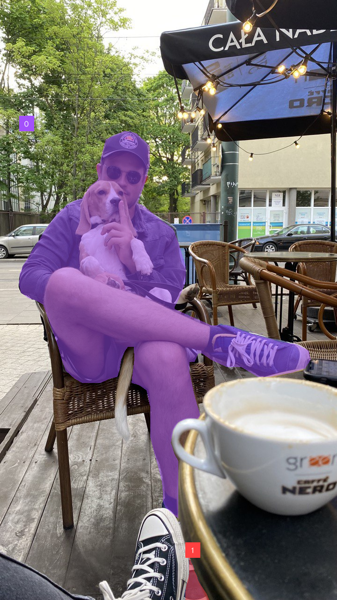

In [ ]:
# @title Example `<REFERRING_EXPRESSION_SEGMENTATION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<REFERRING_EXPRESSION_SEGMENTATION>"
text = "man"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = mask_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [ ]:
!pip install -q jupyter_bbox_widget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.6 MB/s eta 0:00:00


In [ ]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True
IMAGE_PATH = f"{HOME}/data/dog-3.jpeg"

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 156, 'y': 381, 'width': 276, 'height': 558, 'label': ''}]

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 243, 'y': 733, 'width': 52, 'height': 211, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

image = Image.open(IMAGE_PATH)
w, h = image.size
box = box / np.array([w, h, w, h])
box = box * 1000
box = box.astype(np.int32)
box

array([216, 297, 600, 733], dtype=int32)

In [ ]:
region = "".join([f"<loc_{coordinate}>" for coordinate in box])
region

'<loc_216><loc_297><loc_600><loc_733>'

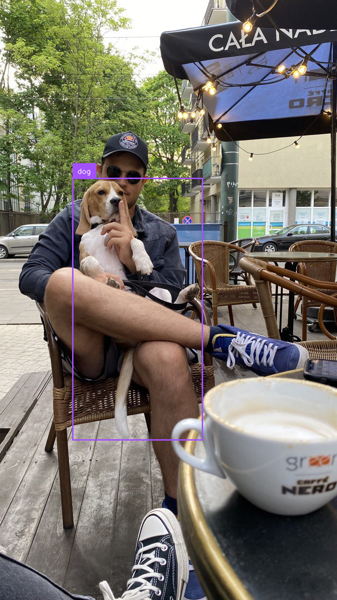

In [ ]:
# @title Example `<REGION_TO_CATEGORY>` inference

import supervision as sv
from PIL import Image

task = "<REGION_TO_CATEGORY>"
image = Image.open(IMAGE_PATH)

response = run_inference(image=image, task=task, text=region)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
detections.xyxy = (detections.xyxy / 1000 * np.array([w, h, w, h])).astype(np.int32)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)

image.thumbnail((600, 600))
image

In [85]:
!pip install sentence-transformers
!pip install sentencepiece
!pip install qwen_vl_utils
!pip install accelerate>=0.26.0
!pip install peft==0.15.1
!pip install bitsandbytes
!pip install pydantic==2.10.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.0/411.0 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.16.0
    Uninstalling peft-0.16.0:
      Successfully uninstalled peft-0.16.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.7/431.7 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.0 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.33.2
    Uninstalling pydantic_core-2.33.2:
      Successfully uninstalled pydantic_core-2.33.2
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.11.7
    Uninstalling pydantic-2.11.7:
      Successfully uninstalled pydantic-2.11.7


In [89]:
import gradio as gr
import time
from PIL import Image
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
import uuid
import os
import numpy as np

# Load model and processor
# model_name = "NAMAA-Space/Qari-OCR-0.1-VL-2B-Instruct"
model_name = "NAMAA-Space/Qari-OCR-0.2.2.1-VL-2B-Instruct"
model = Qwen2VLForConditionalGeneration.from_pretrained(
                model_name,
                torch_dtype="auto",
                device_map="cuda"
            )
processor = AutoProcessor.from_pretrained(model_name)
max_tokens = 2000


@spaces.GPU
def perform_ocr(image):
    inputArray = np.any(image)
    if inputArray == False:
        return "Error Processing"
    """Process image and extract text using OCR model"""
    image = Image.fromarray(image)
    src = str(uuid.uuid4()) + ".png"
    prompt = "Below is the image of one page of a document, as well as some raw textual content that was previously extracted for it. Just return the plain text representation of this document as if you were reading it naturally. Do not hallucinate."
    image.save(src)

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": f"file://{src}"},
                {"type": "text", "text": prompt},
            ],
        }
    ]

    # Process inputs
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Generate text
    generated_ids = model.generate(**inputs, max_new_tokens=max_tokens, use_cache=True)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]

    # Cleanup
    os.remove(src)
    return output_text

# Create Gradio interface
with gr.Blocks(title="Qari Arabic OCR") as demo:
    gr.Markdown("# Qari Arabic OCR")
    gr.Markdown("Upload an image to extract Arabic text in real-time. This model is specialized for Arabic document OCR.")

    with gr.Row():
        with gr.Column(scale=1):
            # Input image
            image_input = gr.Image(type="numpy", label="Upload Image")

            # Example gallery
            gr.Examples(
                examples=[
                    ["2.jpg"],
                    ["3.jpg"]
                ],
                inputs=image_input,
                label="Example Images",
                examples_per_page=4
            )

            # Submit button
            submit_btn = gr.Button("Extract Text")

        with gr.Column(scale=1):
            # Output text
            output = gr.Textbox(label="Extracted Text", lines=20, show_copy_button=True)

            # Model details
            with gr.Accordion("Model Information", open=False):
                gr.Markdown("""
                **Model:** Qari-OCR-0.1-VL-2B-Instruct
                **Description:** Arabic OCR model based on Qwen2-VL architecture
                **Size:** 2B parameters
                **Context window:** Supports up to 2000 output tokens
                """)

    # Set up processing flow
    submit_btn.click(fn=perform_ocr, inputs=image_input, outputs=output)
    image_input.change(fn=perform_ocr, inputs=image_input, outputs=output)


ImportError: Using `bitsandbytes` 4-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`

In [87]:
!pip install -U bitsandbytes

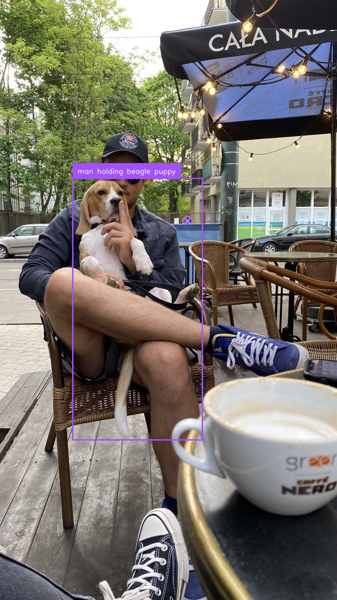

In [ ]:
# @title Example `<REGION_TO_DESCRIPTION>` inference

import supervision as sv
from PIL import Image

task = "<REGION_TO_DESCRIPTION>"
image = Image.open(IMAGE_PATH)

response = run_inference(image=image, task=task, text=region)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
detections.xyxy = (detections.xyxy / 1000 * np.array([w, h, w, h])).astype(np.int32)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)

image.thumbnail((600, 600))
image

# Congratulations

⭐️ If you enjoyed this notebook, [**star the Roboflow Notebooks repo**](https://https://github.com/roboflow/notebooks) (and [**supervision**](https://github.com/roboflow/supervision) while you're at it) and let us know what tutorials you'd like to see us do next. ⭐️